In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10, Loss: 0.6741, Accuracy: 0.6454
Epoch 2/10, Loss: 0.6384, Accuracy: 0.6575
Epoch 3/10, Loss: 0.5965, Accuracy: 0.7149
Epoch 4/10, Loss: 0.5692, Accuracy: 0.7334
Epoch 5/10, Loss: 0.5612, Accuracy: 0.7431
Epoch 6/10, Loss: 0.5565, Accuracy: 0.7399
Epoch 7/10, Loss: 0.5565, Accuracy: 0.7488
Epoch 8/10, Loss: 0.5578, Accuracy: 0.7431
Epoch 9/10, Loss: 0.5528, Accuracy: 0.7472
Epoch 10/10, Loss: 0.5585, Accuracy: 0.7423

Classification Report:
              precision    recall  f1-score   support

        Audi       0.76      0.92      0.83       814
       Swift       0.73      0.43      0.54       424

    accuracy                           0.75      1238
   macro avg       0.75      0.68      0.69      1238
weighted avg       0.75      0.75      0.73      1238



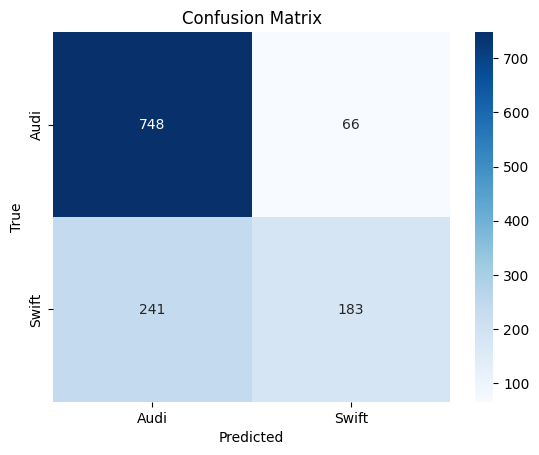

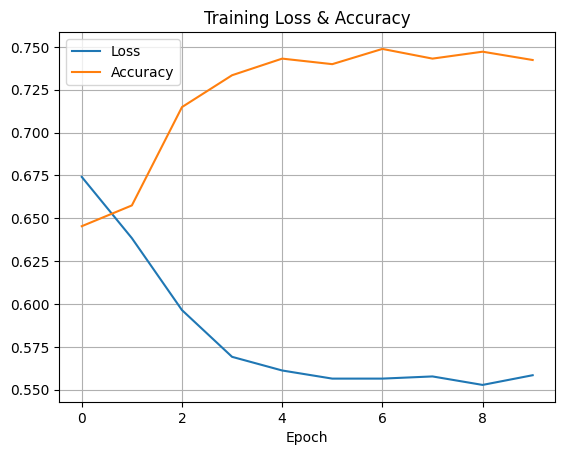

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import timm

# 1. Налаштування
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
IMG_SIZE = 224

# 2. Трансформації
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# 3. Завантаження тільки Audi і Swift
data_dir = "/content/drive/MyDrive/Cars Dataset/train"
allowed_classes = ['Audi', 'Swift']

class FilteredDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [s for s in self.samples if self.classes[s[1]] in allowed_classes]
        self.targets = [s[1] for s in self.samples]
        self.class_to_idx = {cls: i for i, cls in enumerate(allowed_classes)}
        self.samples = [(s[0], self.class_to_idx[self.classes[s[1]]]) for s in self.samples]

dataset = FilteredDataset(data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Модель Vision Transformer (маленький варіант)
model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model = model.to(DEVICE)

# 5. Втрати і оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 6. Тренування
train_losses = []
train_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# 7. Оцінка
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=allowed_classes))

# Матриця плутанини
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, xticklabels=allowed_classes, yticklabels=allowed_classes, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 8. Графік loss/accuracy
plt.plot(train_losses, label='Loss')
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Loss & Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()
